In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime, timedelta
from scipy import stats

import yfinance as yf
import pandas as pd
import numpy as np

import warnings

warnings.simplefilter("ignore", ConvergenceWarning)


### Download

In [3]:
TICKER = "DUOL"
INTERVAL = "1d"
FILENAME = f"{TICKER}-{INTERVAL}.csv"

ticker = yf.Ticker(TICKER)
df = pd.DataFrame()

delta = timedelta(days=365)
# delta = timedelta(days=8) # Uncomment if your interval is 1 minute
end = datetime.now()
start = end - delta

while True:
    history = ticker.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval=INTERVAL)

    if len(history) == 0:
        break

    print(f"Got {history.shape[0]} rows from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}.")

    df = pd.concat([df, history])
    end -= delta
    start -= delta

df.sort_index(ascending=True, inplace=True)
df.index.name = "Date"

df.to_csv(FILENAME)
print(f"Saved to {FILENAME}")

df

Got 249 rows from 2024-06-09 to 2025-06-09.
Got 250 rows from 2023-06-10 to 2024-06-09.
Got 251 rows from 2022-06-10 to 2023-06-10.
Got 220 rows from 2021-06-10 to 2022-06-10.


$DUOL: possibly delisted; no price data found  (1d 2020-06-10 -> 2021-06-10) (Yahoo error = "Data doesn't exist for startDate = 1591761600, endDate = 1623297600")


Saved to DUOL-1d.csv


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-28 00:00:00-04:00,141.399994,145.000000,130.000000,134.255005,2887900,0.0,0.0
2021-07-29 00:00:00-04:00,137.000000,139.000000,132.000000,134.440002,693900,0.0,0.0
2021-07-30 00:00:00-04:00,135.179993,141.399994,128.500000,140.250000,617700,0.0,0.0
2021-08-02 00:00:00-04:00,140.000000,147.250000,134.720001,143.800003,586600,0.0,0.0
2021-08-03 00:00:00-04:00,143.160004,146.990005,138.009995,139.860001,740100,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-02 00:00:00-04:00,519.760010,528.070007,513.210022,526.849976,680500,0.0,0.0
2025-06-03 00:00:00-04:00,529.570007,534.500000,512.000000,513.369995,691500,0.0,0.0
2025-06-04 00:00:00-04:00,515.000000,523.325012,510.670013,518.789978,638100,0.0,0.0


### Load CSV

In [4]:
# df = pd.read_csv(FILENAME)
df = pd.read_csv("COST-1d.csv")
df.sort_index(ascending=True, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], utc=True)

START_DATE = None
END_DATE = None

# START_DATE = pd.to_datetime("2019-11-01", utc=True)
# END_DATE = pd.to_datetime("2020-05-01", utc=True)

try:
    df = df[(df["Date"] >= START_DATE) & (df["Date"] <= END_DATE)]
    print(f"Filtered data from {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}.")
except:
    pass

# Log prices
open_series = pd.Series([np.log(x) for x in df["Open"].values])

df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-07-09 04:00:00+00:00,7.160097,7.411329,7.076353,7.369457,1116800,0.0,0.0
1,1986-07-10 04:00:00+00:00,7.411329,7.453200,7.160097,7.327585,595600,0.0,0.0
2,1986-07-11 04:00:00+00:00,7.285710,7.327582,7.076351,7.076351,800400,0.0,0.0
3,1986-07-14 04:00:00+00:00,7.118226,7.118226,6.783251,6.866995,738000,0.0,0.0
4,1986-07-15 04:00:00+00:00,6.825122,6.825122,6.238915,6.657634,2059200,0.0,0.0
...,...,...,...,...,...,...,...,...
9799,2025-05-30 04:00:00+00:00,1002.299988,1052.489990,1002.000000,1040.180054,5403800,0.0,0.0
9800,2025-06-02 04:00:00+00:00,1034.270020,1060.500000,1034.270020,1056.849976,2148000,0.0,0.0
9801,2025-06-03 04:00:00+00:00,1054.150024,1067.079956,1043.260010,1055.589966,1992900,0.0,0.0
9802,2025-06-04 04:00:00+00:00,1055.000000,1057.829956,1049.369995,1051.689941,1422100,0.0,0.0


### Correlations

In [5]:
correlations = pd.concat([open_series.shift(i) for i in [0, 1, 5, 10, 30]], axis=1)
correlations.columns = ["t", "t+1", "t+5", "t+10", "t+30"]
corr_table = correlations.corr()

threshold = 0.01
diff = (1 - corr_table).abs()
mask = diff > threshold

if mask.values.any():
    print(f"WARNING: there are correlations >{threshold} away from 1. This data may not be predictable!")
    print(corr_table.where(mask).stack())

corr_table

,t,t+1,t+5,t+10,t+30
t,1.000000,0.999914,0.999603,0.999265,0.997883
t+1,0.999914,1.000000,0.999676,0.999332,0.997953
t+5,0.999603,0.999676,1.000000,0.999603,0.998222
t+10,0.999265,0.999332,0.999603,1.000000,0.998572
t+30,0.997883,0.997953,0.998222,0.998572,1.000000


### Visualize

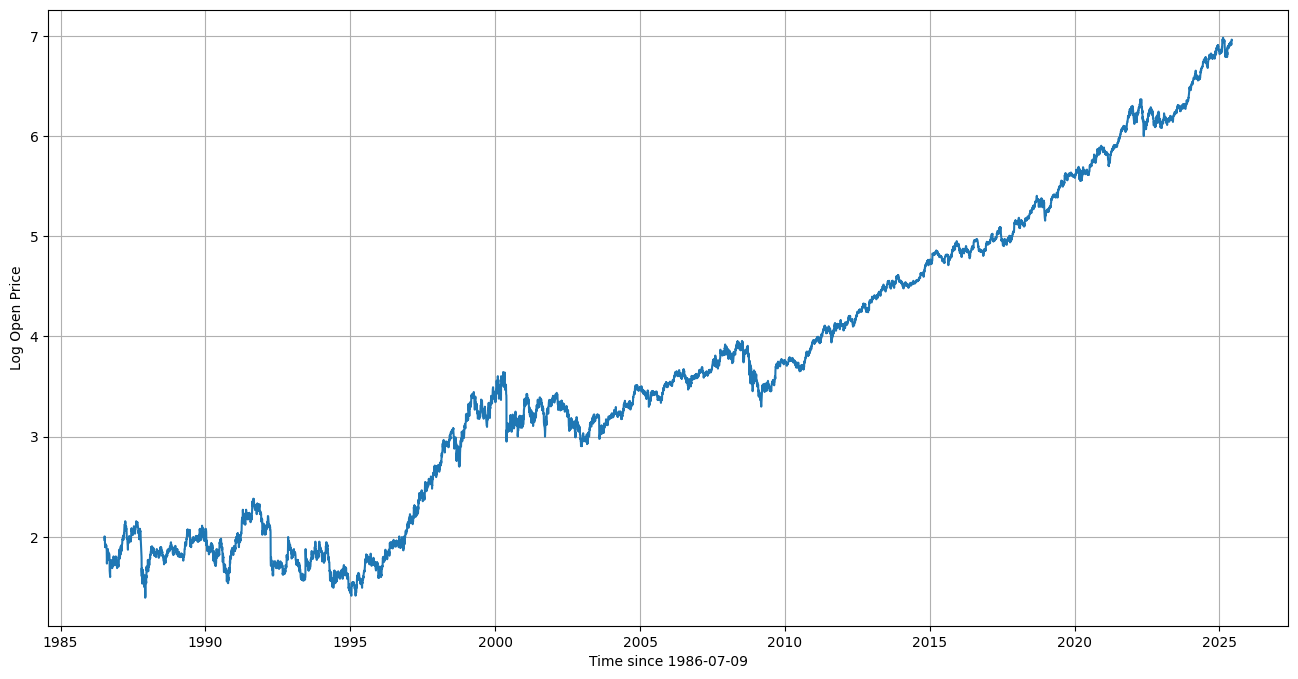

In [6]:
x_caption = f"Time since {df["Date"].min().strftime("%Y-%m-%d")}"

plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel(x_caption)
plt.ylabel("Log Open Price")
plt.plot(df["Date"], open_series)

### Statistics

Significance level: 0.05
Differenced 1 time


,Count,Mean,Variance,Min,Max,Skew,Kurtosis,Jarque-Bera,Normal?,ADF,Stationary?
0,9804,3.657848,2.242054,1.391208,6.98015,0.359421,-0.86881,0.0,False,0.992348,False
1,9804,0.000509,0.000386,-0.409842,0.170958,-0.915513,24.049195,0.0,False,0.0,True


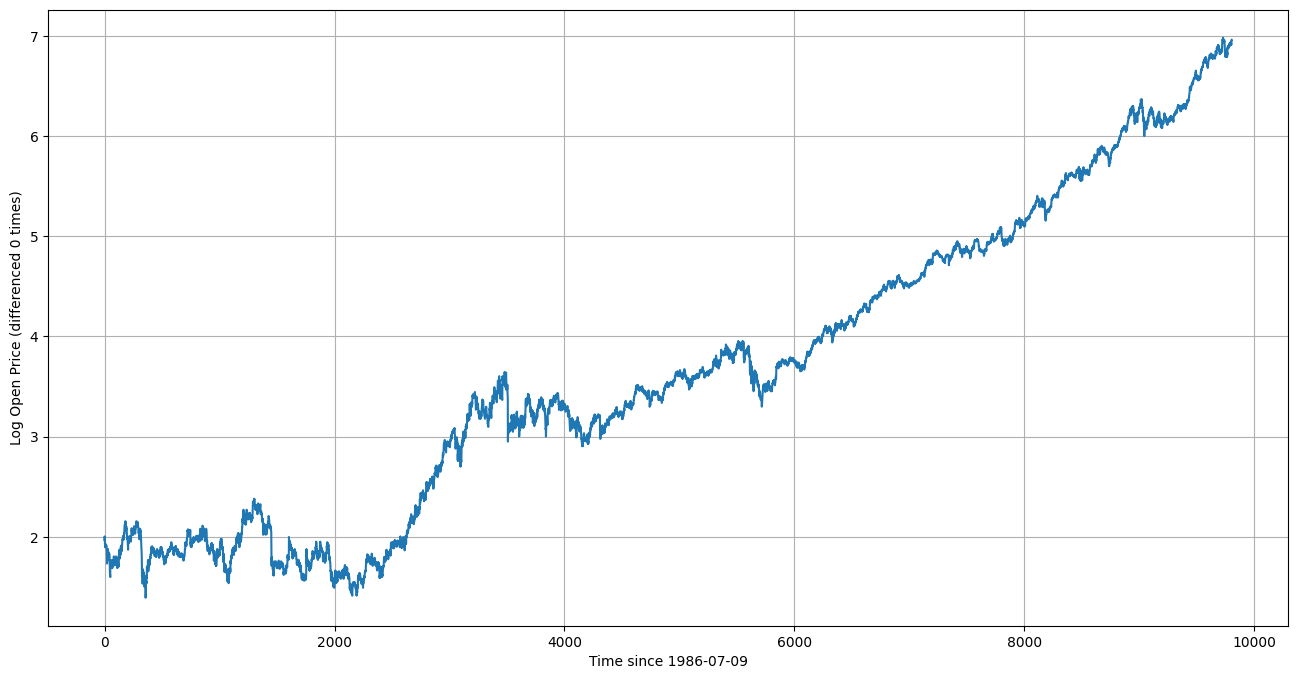

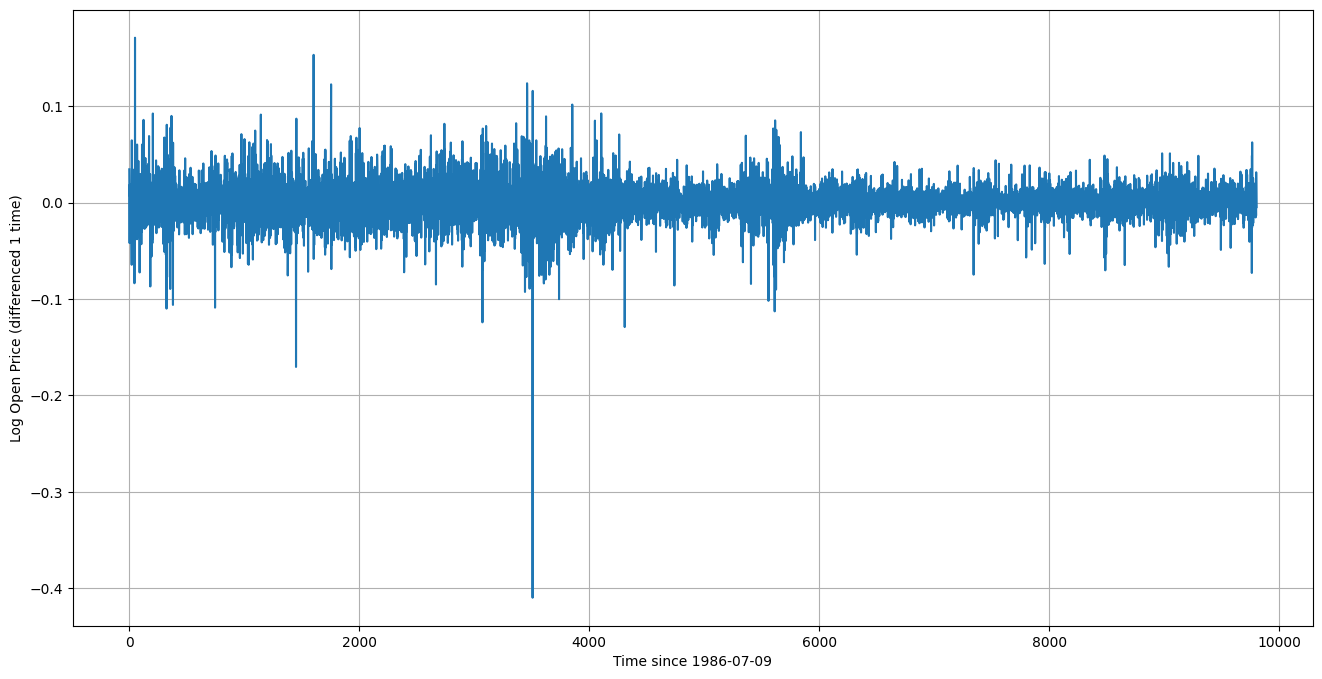

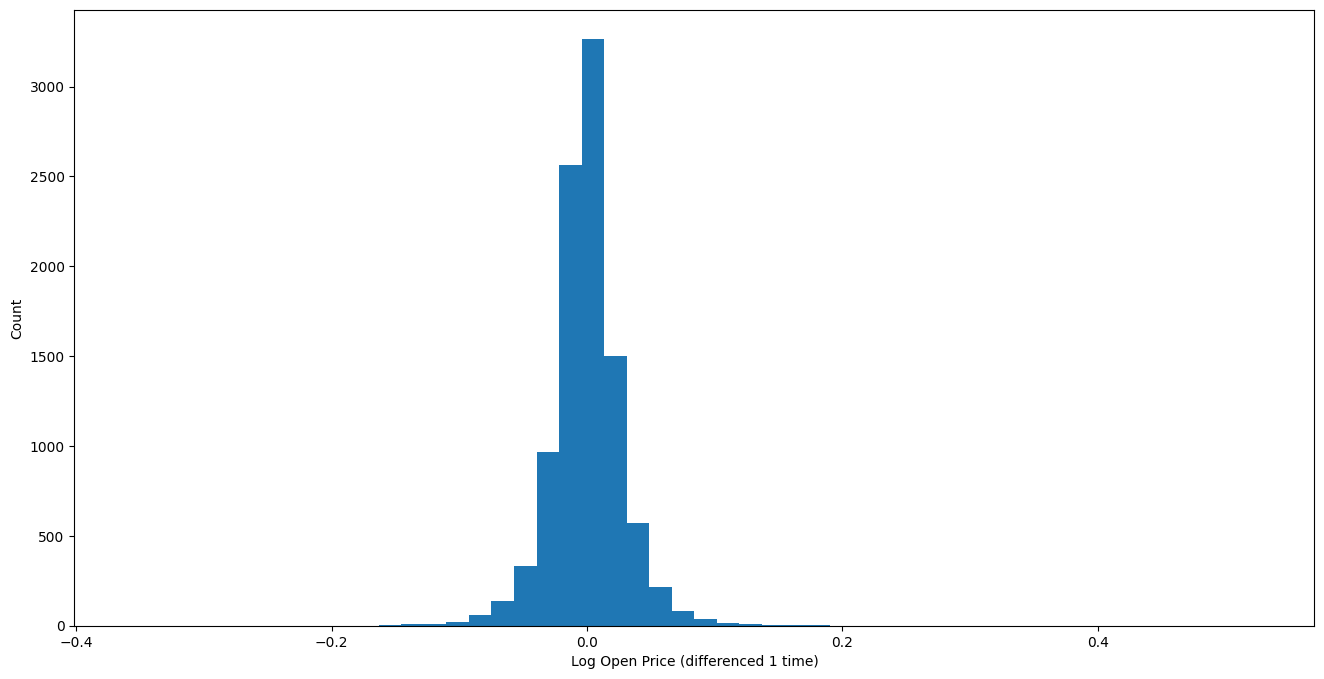

In [7]:
returns = open_series.copy(deep=True)
returns_stats = pd.DataFrame(columns=["Count", "Mean", "Variance", "Min", "Max", "Skew", "Kurtosis", "Jarque-Bera", "Normal?", "ADF", "Stationary?"])
integrations = -1

SIGNIFICANCE = 0.05

# Difference until the data is stationary
while True:
    integrations += 1

    mean = returns.values.mean()
    var = returns.values.var()
    minimum = returns.values.min()
    maximum = returns.values.max()
    skew = stats.skew(returns.values)
    kurtosis = stats.kurtosis(returns.values)

    normality = stats.jarque_bera(returns.values)[1]
    stationarity = adfuller(returns.values)[1]

    new_row = pd.Series({
        "Count": len(df),
        "Mean": mean,
        "Variance": var,
        "Min": minimum,
        "Max": maximum,
        "Skew": skew,
        "Kurtosis": kurtosis,
        "Jarque-Bera": normality,
        "Normal?": normality >= SIGNIFICANCE,
        "ADF": stationarity,
        "Stationary?": stationarity < SIGNIFICANCE,
    })
    returns_stats.loc[integrations] = new_row

    plt.figure(figsize=(16, 8))
    plt.grid(True)
    plt.xlabel(x_caption)
    plt.ylabel(f"Log Open Price (differenced {integrations} time{'' if integrations == 1 else 's'})")
    plt.plot(range(len(returns)), returns)

    # Intentionally difference at least once, even if we don't need to for it to be stationary
    returns = returns.diff().dropna()

    if stationarity < SIGNIFICANCE:
        break

print(f"Significance level: {SIGNIFICANCE}")
print(f"Differenced {integrations} time{'' if integrations == 1 else 's'}")

plt.figure(figsize=(16, 8))
plt.xlabel(f"Log Open Price (differenced {integrations} time{'' if integrations == 1 else 's'})")
plt.ylabel("Count")
plt.hist(returns, bins=50)

returns_stats

### Train-Test Split

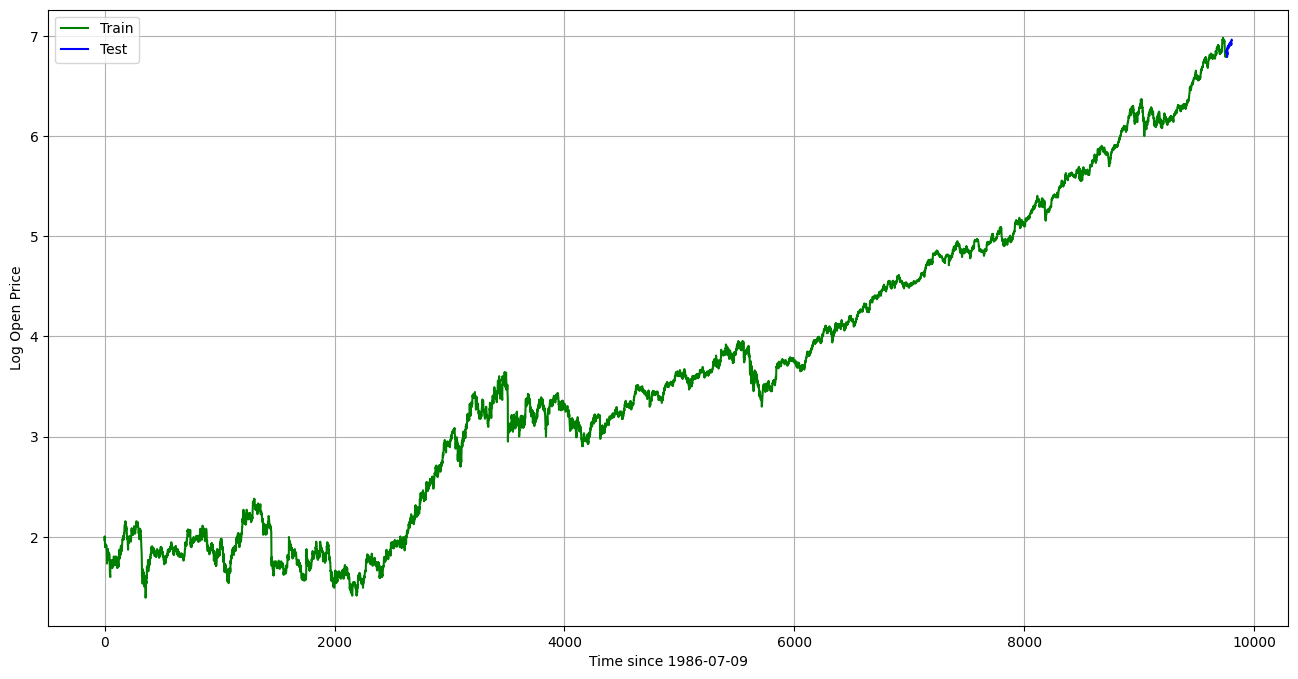

In [8]:
# 80-20 split
# split = int(len(open_series) * 0.8)

# Test on last 50 values
split = len(open_series) - 50
train, test = open_series[0:split], open_series[split:]

plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel(x_caption)
plt.ylabel("Log Open Price")
plt.plot(range(len(train)), train, "green", label="Train")
plt.plot(range(len(train), len(train) + len(test)), test, "blue", label="Test")
plt.legend()

### Select ARMA Parameters

In [9]:
# ic = arma_order_select_ic(train, max_ar=5, max_ma=5, ic="aic", trend="n")
# p, q = ic.aic_min_order

# Alternatively, comment above since it's slow and just use these, which is a good result in my testing:
p, q = (1, 3)

print(f"Akaike Inference Criterion selected (p, q) = ({p}, {q})")

Akaike Inference Criterion selected (p, q) = (1, 3)


### Fit ARMA

In [10]:
arma = ARIMA(train, order=(p, integrations, q), trend="n")
arma_res = arma.fit()

param_names = arma_res.param_names
params      = arma_res.params
p_vals      = arma_res.pvalues
aic         = arma_res.aic
resid       = arma_res.resid

# Autocorrelated-ness
lb = acorr_ljungbox(resid, lags=[1], return_df=True).iloc[0]
lb_pval = lb["lb_pvalue"]

# Heteroskedasticity
_, engle_pval, _, _ = het_arch(resid)

# All, or at least most, coefficients should be significant.
# If this is not the case, AIC selected some strange (p, q). Maybe try the hard-coded ones?
print(f"ARMA({p}, {q}):")
for term, c, pval in zip(param_names, params, p_vals):
    print(f"{term}: {c:.4f}, p={pval:.4f} ({'significant' if pval < SIGNIFICANCE else 'not significant'})")

# Lower is better
print()
print(f"AIC: {aic:.4f}")
print()

# There should be no autocorrelations and there should be heteroskedasticity (so we can use GARCH)
print(f"Residuals:")
print(f"Autocorrelated: {'yes' if lb_pval < SIGNIFICANCE else 'no'} (p={lb_pval:.4f})")
print(f"Heteroskedastic: {'yes' if engle_pval < SIGNIFICANCE else 'no'} (p={engle_pval:.4f})")

ARMA(1, 3):
ar.L1: 0.6957, p=0.0000 (significant)
ma.L1: -0.7167, p=0.0000 (significant)
ma.L2: -0.0006, p=0.9463 (not significant)
ma.L3: -0.0159, p=0.0914 (not significant)
sigma2: 0.0004, p=0.0000 (significant)

AIC: -48976.2324

Residuals:
Autocorrelated: no (p=0.3958)
Heteroskedastic: yes (p=0.0000)


### Predict

[924.53502189 926.09561677] 933.1142184671438
[935.15811815 935.59918253] 928.3503985219488
[928.36733868 929.15576554] 936.2800813955298
[937.5984403  937.92310089] 921.1598077286252
[920.46835077 921.24166855] 941.19368922949
[943.10537383 942.85224793] 949.6027581253766
[949.68224042 950.30269543] 929.868439609766
[929.37427697 930.50891311] 953.7573100603051
[956.1223956  955.70234713] 886.594817764898
[885.56026918 885.58827064] 930.837173972292
[929.88021396 928.06959329] 906.8184961204144
[906.16310812 909.15705645] 965.2423896253335
[961.31611273 965.57127071] 962.7057051680412
[966.86750964 965.73651489] 968.7378352089436
[967.51288436 968.04874588] 984.0678271860406
[983.98386917 985.06119422] 970.8650280909465
[975.6584925  972.02009121] 972.0135738516706
[968.54809816 971.06579236] 991.707880918964
[991.28453309 992.63510131] 968.4881049444692
[970.64227146 969.24630883] 993.22593749779
[990.7950435  992.52519127] 972.3330738070492
[975.08211711 973.62912229] 972.7026371717

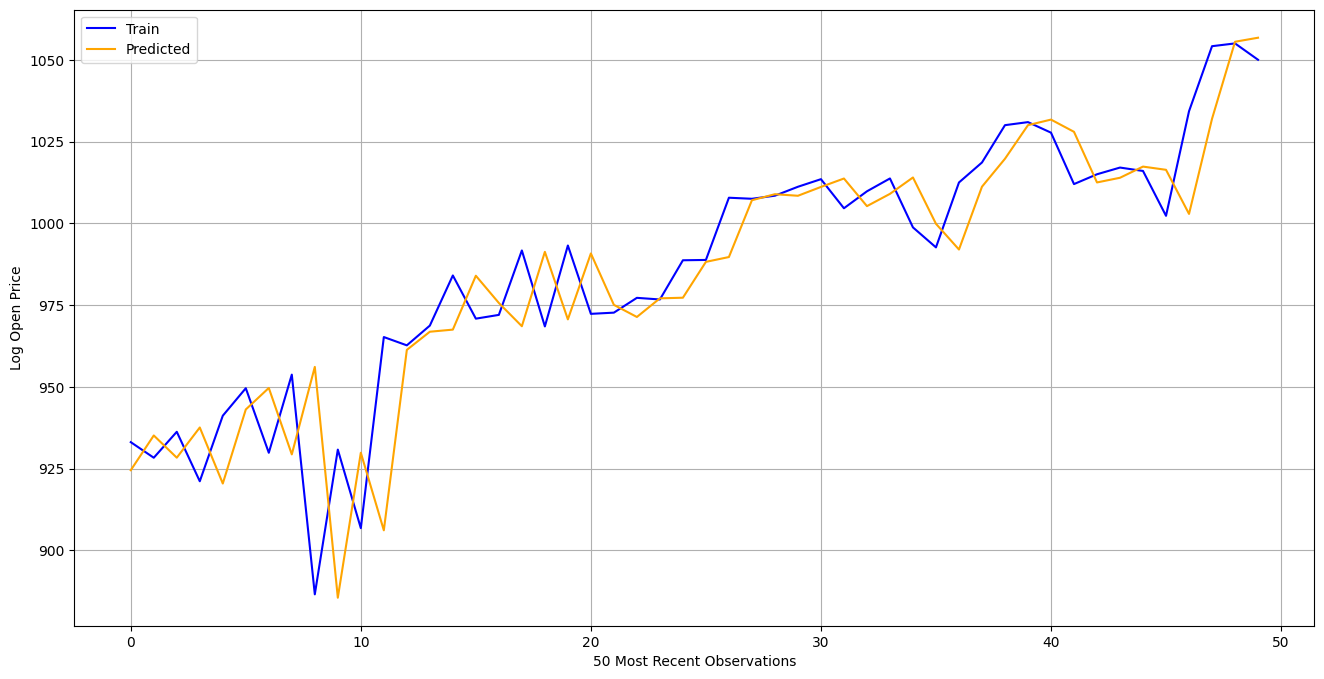

In [11]:
# Prediction of testing data

# history_endog = list(train.copy(deep=True))
# informed_pred = []
# for obs in test: 
#     model = ARIMA(endog=history_endog, order=(p, i, q), trend="n")
#     model_fit = model.fit()
#     forecast = model_fit.forecast()[0]

#     informed_pred.append(forecast)
#     history_endog.append(obs)
train, test = [df["Open"][:split], df["Open"][split:]]
history_endog = list(train.copy(deep=True))
pred = []
for i, obs in enumerate(test): 
    # if i > 5: break
    model = ARIMA(endog=history_endog, order=(p, integrations, q), trend="t")
    forecast = model.fit().forecast(steps=2)
    print(forecast, obs)

    pred.append(forecast[0])
    history_endog.append(obs)

# pred = arma_res.predict(end=(len(train) + len(test)), signal_only=True, dynamic=len(train))[len(train) - 5:]


# pred = arma_res.forecast(steps=50)

plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel("50 Most Recent Observations")
plt.ylabel("Log Open Price")
# plt.plot(range(len(test)), test, "blue", label="Test")
plt.plot(range(50), [0] + test, "blue", label="Train")
# plt.plot(range(len(informed_pred)), informed_pred, "orange", label="Informed Predicted")
plt.plot(range(len(pred)), pred, "orange", label="Predicted")
plt.legend()